In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df1 = pd.read_csv('Datasets/Code_Violations.csv')
df2 = pd.read_csv('Datasets/Code_Violations-1.csv')
code_violations = pd.concat([df1, df2], ignore_index=True)
print(code_violations.shape)

(98420, 24)


Step 1. Data cleaning and transformation

In [3]:
# 1. Glimpse the dataset
code_violations.dtypes
# Many of these columns are chracters

X                      float64
Y                      float64
violation_number        object
complaint_address       object
complaint_zip            int64
SBL                     object
violation               object
violation_date          object
comply_by_date          object
status_type_name        object
complaint_number        object
complaint_type_name     object
open_date               object
owner_name              object
inspector_id             int64
Neighborhood            object
Vacant                  object
owner_address           object
owner_city              object
owner_state             object
owner_zip_code          object
Latitude               float64
Longitude              float64
ObjectId                 int64
dtype: object

In [4]:
code_violations.head()

,X,Y,violation_number,complaint_address,complaint_zip,SBL,violation,violation_date,comply_by_date,status_type_name,...,inspector_id,Neighborhood,Vacant,owner_address,owner_city,owner_state,owner_zip_code,Latitude,Longitude,ObjectId
0,-8.480408e+06,5.317057e+06,2021-14216,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2021/08/27 14:20:05.683+00,2021/09/03 14:20:05+00,Closed,...,247,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,18
1,-8.480408e+06,5.317057e+06,2021-07690,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2021/05/20 15:28:46.050+00,2021/05/27 15:28:46+00,Closed,...,247,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,20
2,-8.480408e+06,5.317057e+06,2020-03502,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC 27-43 (e) (1)(2)(3)(4) Certification,2020/09/29 08:47:31.553+00,2020/10/20 08:47:31+00,Closed,...,253,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,22
3,-8.480408e+06,5.317057e+06,2020-02530,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2020/08/31 12:09:43+00,2020/09/07 00:00:00+00,Closed,...,750,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,24
4,-8.480408e+06,5.317057e+06,98169,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2020/05/26 11:13:15+00,2020/06/02 00:00:00+00,Closed,...,661,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,26


In [5]:
# 2. convert date string to datetime type
code_violations['violation_date']=pd.to_datetime(code_violations['violation_date'])
code_violations['comply_by_date']=pd.to_datetime(code_violations['comply_by_date'])
# Should be datetime here, time zone by default is UTC, I think it should be EDT or EST since it's in Syracuse
print(code_violations[['comply_by_date','violation_date']].dtypes)

# Find the date range
print('violation date range: '+str(code_violations['violation_date'].dt.date.min()) + ' to ' +str(code_violations['violation_date'].dt.date.max()))
print('violation complied date range: '+str(code_violations['comply_by_date'].dt.date.min()) + ' to ' +str(code_violations['comply_by_date'].dt.date.max()))
# It's about 5 years
# Some of the comply_by_date seems not right by showing 1900-01-01

comply_by_date    datetime64[ns, UTC]
violation_date    datetime64[ns, UTC]
dtype: object
violation date range: 2018-12-26 to 2023-10-27
violation complied date range: 1900-01-01 to 2023-12-28


In [6]:
# 3. mark the potential bad values
# check if the original character just read 1900/01/01
index_bad_comply_by_date=code_violations[code_violations['comply_by_date']=='1900-01-01'].index
temp_table=pd.concat([df1, df2], ignore_index=True)
print(temp_table.iloc[index_bad_comply_by_date,].shape[0])
# There are 119 rows having comply_by_date of 1900/01/01
print(temp_table.iloc[index_bad_comply_by_date,8].head())
del temp_table
# Threr are 2 possible reason this happens: 1. bad records. 
# 2. (I don't know what exactly this comply_by_date means), if it is a designated date the owner should comply the violation, then fine, maybe it gives no information. 
# However, if the date violation is actually complied, then we can calculate the date duration 

# index_bad_comply_by_date is kept, if we want do some calculations involved with two type of dates, we could exclude these rows.

119
690     1900/01/01 00:00:00+00
720     1900/01/01 00:00:00+00
1018    1900/01/01 00:00:00+00
1020    1900/01/01 00:00:00+00
2188    1900/01/01 00:00:00+00
Name: comply_by_date, dtype: object


In [7]:
# Now check the dataset
code_violations.head()

,X,Y,violation_number,complaint_address,complaint_zip,SBL,violation,violation_date,comply_by_date,status_type_name,...,inspector_id,Neighborhood,Vacant,owner_address,owner_city,owner_state,owner_zip_code,Latitude,Longitude,ObjectId
0,-8.480408e+06,5.317057e+06,2021-14216,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2021-08-27 14:20:05.683000+00:00,2021-09-03 14:20:05+00:00,Closed,...,247,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,18
1,-8.480408e+06,5.317057e+06,2021-07690,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2021-05-20 15:28:46.050000+00:00,2021-05-27 15:28:46+00:00,Closed,...,247,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,20
2,-8.480408e+06,5.317057e+06,2020-03502,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC 27-43 (e) (1)(2)(3)(4) Certification,2020-09-29 08:47:31.553000+00:00,2020-10-20 08:47:31+00:00,Closed,...,253,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,22
3,-8.480408e+06,5.317057e+06,2020-02530,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2020-08-31 12:09:43+00:00,2020-09-07 00:00:00+00:00,Closed,...,750,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,24
4,-8.480408e+06,5.317057e+06,98169,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2020-05-26 11:13:15+00:00,2020-06-02 00:00:00+00:00,Closed,...,661,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,26


In [8]:
# 4. combine with demographic data (from US census)
import requests

# getting our zipcodes of interest
unique_zipcodes = code_violations['complaint_zip'].unique()
zipcodes_str = ','.join(map(str, unique_zipcodes))
state = '36'

api_url = 'https://api.census.gov/data/2019/acs/acs5/profile'
params = {
    # total population, median household income, est white population
    'get': 'NAME,DP05_0001E,DP03_0062E,DP05_0014E',
    'for': f'zip code tabulation area:{zipcodes_str}',
    'in': f'state:{state}',
    'key': '766b906ae7f8eaf962beff4b707574f968d40e3b'
}

response = requests.get(api_url, params=params)
if response.status_code == 200:
    data = response.json()

else:
    # Print an error message if the request was not successful
    print(f"Error: {response.status_code}, {response.text}")


In [9]:
# converting JSON to dataframe and cleaning
zip_data = df = pd.DataFrame(data[1:], columns=data[0])

# filtering columns
selected_columns = ['DP05_0001E', 'DP03_0062E', 'DP05_0014E', 'zip code tabulation area']
zip_data = zip_data[selected_columns]
zip_data

# rename remaining columns
zip_data = zip_data.rename(columns={
    'DP05_0001E': 'Total Population',
    'DP03_0062E': 'Median Household Income',
    'DP05_0014E': 'White Population',
    'zip code tabulation area': 'zipcode'
})
zip_data

,Total Population,Median Household Income,White Population,zipcode
0,16513,38018,1044,13203
1,14952,92575,1139,13215
2,6787,20196,159,13202
3,18741,34856,923,13204
4,12597,53012,807,13207
5,16723,43674,1207,13206
6,17212,32579,1161,13205
7,27916,31319,840,13210
8,8369,62485,661,13224
9,22833,38475,1163,13208


In [10]:
# converting zipcodes to int64 to match complaint_zip type
zip_data['zipcode'] = zip_data['zipcode'].astype('int64')

# merging with code violations data
code_violations = pd.merge(code_violations, zip_data, left_on='complaint_zip', right_on='zipcode', how='left')

# deleting extra zip column
code_violations = code_violations.drop(columns=['zipcode'])
code_violations.sample(5)

,X,Y,violation_number,complaint_address,complaint_zip,SBL,violation,violation_date,comply_by_date,status_type_name,...,owner_address,owner_city,owner_state,owner_zip_code,Latitude,Longitude,ObjectId,Total Population,Median Household Income,White Population
71860,-8.474486e+06,5.317819e+06,2021-17741,119 Clarendon St,13210,046.-16-15.0,SZC - Section VIII-4- Certificate of Suitability,2021-10-26 08:37:38.633000+00:00,2021-11-12 08:37:38+00:00,Open,...,PO BOX 651489,Vero Beach,FL,39265,43.0384,-76.1276,49378,27916,31319,840
88626,-8.475988e+06,5.322160e+06,2022-18224,307 Hier Ave,13203,010.-29-06.0,2020 PMCNYS - Section 305.3 - interior surfaces,2022-09-29 08:54:10.820000+00:00,2022-10-17 08:52:59+00:00,Closed,...,187 Shotwell Pk,Syracuse,NY,13206,43.0669,-76.1411,80445,16513,38018,1044
72098,-8.477246e+06,5.320545e+06,2022-00260,413-15 Salina St N To Salt St,13203,017.-02-13.0,2020 PMCNYS - Section 603.1 - Mechanical equip...,2022-01-05 15:56:07.797000+00:00,2022-01-26 15:56:07+00:00,Open,...,4396 Colburn Dr,Syracuse,NY,13215,43.0563,-76.1524,49863,16513,38018,1044
83872,-8.476868e+06,5.315595e+06,2023-00417,144-46 Fage Ave,13205,077.-01-27.0,SPCC-Sec. 27-133 Registration,2023-01-10 10:47:40.693000+00:00,2023-01-31 10:47:40+00:00,Open,...,PO BOX 596,SYRACUSE,NY,13205,43.0238,-76.1490,71599,17212,32579,1161
80358,-8.476534e+06,5.313327e+06,2022-17500,168 Dawes Ave & Slayton Ave,13205,072.-13-14.0,SPCC-Sec. 27-133 Registration,2022-09-20 15:17:21.103000+00:00,2023-01-03 15:17:21+00:00,Closed,...,56 Shore Rd,Tiverton,RI,02878,43.0089,-76.1460,65316,17212,32579,1161


In [11]:
# 5. altering violation column
violation_names = code_violations['violation'].unique()
#print(violation_names)

# the majority of violations contain the info we really want after the last hyphen
code_violations['violation name'] = code_violations['violation']
# adding a space before the hyphen prevents us from splitting on a range (ex: 27-15)
code_violations['violation name'] = code_violations['violation name'].apply(lambda x: x.rsplit(' -', 1)[-1].strip())
code_violations

,X,Y,violation_number,complaint_address,complaint_zip,SBL,violation,violation_date,comply_by_date,status_type_name,...,owner_city,owner_state,owner_zip_code,Latitude,Longitude,ObjectId,Total Population,Median Household Income,White Population,violation name
0,-8.480408e+06,5.317057e+06,2021-14216,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2021-08-27 14:20:05.683000+00:00,2021-09-03 14:20:05+00:00,Closed,...,Little Neck,NY,11363,43.0334,-76.1808,18,18741,34856,923,Overgrowth
1,-8.480408e+06,5.317057e+06,2021-07690,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2021-05-20 15:28:46.050000+00:00,2021-05-27 15:28:46+00:00,Closed,...,Little Neck,NY,11363,43.0334,-76.1808,20,18741,34856,923,Overgrowth
2,-8.480408e+06,5.317057e+06,2020-03502,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC 27-43 (e) (1)(2)(3)(4) Certification,2020-09-29 08:47:31.553000+00:00,2020-10-20 08:47:31+00:00,Closed,...,Little Neck,NY,11363,43.0334,-76.1808,22,18741,34856,923,SPCC 27-43 (e) (1)(2)(3)(4) Certification
3,-8.480408e+06,5.317057e+06,2020-02530,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2020-08-31 12:09:43+00:00,2020-09-07 00:00:00+00:00,Closed,...,Little Neck,NY,11363,43.0334,-76.1808,24,18741,34856,923,Overgrowth
4,-8.480408e+06,5.317057e+06,98169,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2020-05-26 11:13:15+00:00,2020-06-02 00:00:00+00:00,Closed,...,Little Neck,NY,11363,43.0334,-76.1808,26,18741,34856,923,Overgrowth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98415,-8.476467e+06,5.322191e+06,2021-17327,501 John St & Gilbert Ave,13208,009.-12-16.0,SPCC - Section 27-72 (e) -Trash & Debris,2021-10-20 15:48:06.807000+00:00,2021-10-28 15:48:06+00:00,Closed,...,Newark,DE,19702,43.0671,-76.1454,99990,22833,38475,1163,Trash & Debris
98416,-8.475855e+06,5.321612e+06,2021-17282,402 Park St,13203,015.-08-07.0,SPCC SEC. 27-15,2021-10-20 10:33:49.120000+00:00,2021-12-20 10:33:49+00:00,Open,...,Syracuse,NY,13214,43.0633,-76.1399,99993,16513,38018,1044,SPCC SEC. 27-15
98417,-8.475599e+06,5.324050e+06,2021-16959,627 Darlington Rd,13208,005.-16-09.0,2020 PMCNYS - Section 305.3 - interior surfaces,2021-10-13 14:43:47.820000+00:00,2021-11-03 14:43:47+00:00,Closed,...,Syracuse,NY,13219,43.0793,-76.1376,99995,22833,38475,1163,interior surfaces
98418,-8.475599e+06,5.324050e+06,2021-16953,627 Darlington Rd,13208,005.-16-09.0,2020 PMCNYS - Section 505.1 - General,2021-10-13 14:27:49.943000+00:00,2021-11-03 14:27:49+00:00,Closed,...,Syracuse,NY,13219,43.0793,-76.1376,99997,22833,38475,1163,General


Step 2. Some descriptive analysis and plotting

In [12]:
# 1. It seems this dataset has many duplicated rows or values for every column, how many unique values are there in each column?
for column in code_violations:
    print(str(code_violations[column].unique().shape[0])+'/98420'+f' unique {column}')
print('unique 12 complaint_zip shown in the list: '+str(code_violations['complaint_zip'].unique()))
print('unique 3 status types shown in the list: '+str(code_violations['status_type_name'].unique()))
print('unique 3 Vacant types shown in the list: '+str(code_violations['Vacant'].unique()))
# violation_number are smaller than row counts, this might means there are many rows mentioning the same violation case
# There are only about 10k out of 100k unique complaint address
# unique complaint_address and SBL have almost the same number, I think these two columns might be highly associated, but need further check.
# unique complaint_number are just 1/3 of the total rows, this might means many rows have the same complaint_number

# About X and Y, I believe it's the coordinate in a projected coordinate system, however, if we cannot find which one this dataset is using, X and Y would be of limited use.
# If we want to project the data from a geographic coordinate system, we can just use long/lats

1125/98420 unique X
925/98420 unique Y
81363/98420 unique violation_number
13565/98420 unique complaint_address
12/98420 unique complaint_zip
13564/98420 unique SBL
793/98420 unique violation
75041/98420 unique violation_date
54992/98420 unique comply_by_date
3/98420 unique status_type_name
34483/98420 unique complaint_number
43/98420 unique complaint_type_name
28580/98420 unique open_date
9924/98420 unique owner_name
59/98420 unique inspector_id
35/98420 unique Neighborhood
3/98420 unique Vacant
9337/98420 unique owner_address
874/98420 unique owner_city
53/98420 unique owner_state
1127/98420 unique owner_zip_code
925/98420 unique Latitude
1125/98420 unique Longitude
98420/98420 unique ObjectId
12/98420 unique Total Population
12/98420 unique Median Household Income
12/98420 unique White Population
620/98420 unique violation name
unique 12 complaint_zip shown in the list: [13204 13202 13206 13208 13205 13203 13207 13210 13214 13224 13215 13219]
unique 3 status types shown in the list:

In [15]:
# 2. What are the violation types and how frequent each type is
violation_counts=code_violations.groupby('violation name')['X'].count().to_frame().sort_values(by=['X'],ascending=False)
violation_counts=violation_counts.reset_index()
violation_counts.describe(percentiles=[.25,.75,.90])

,X
count,620.000000
mean,158.711290
std,687.962217
min,1.000000
25%,2.000000
50%,7.000000
75%,49.000000
90%,304.300000
max,9887.000000


<AxesSubplot:xlabel='violation name', ylabel='X'>

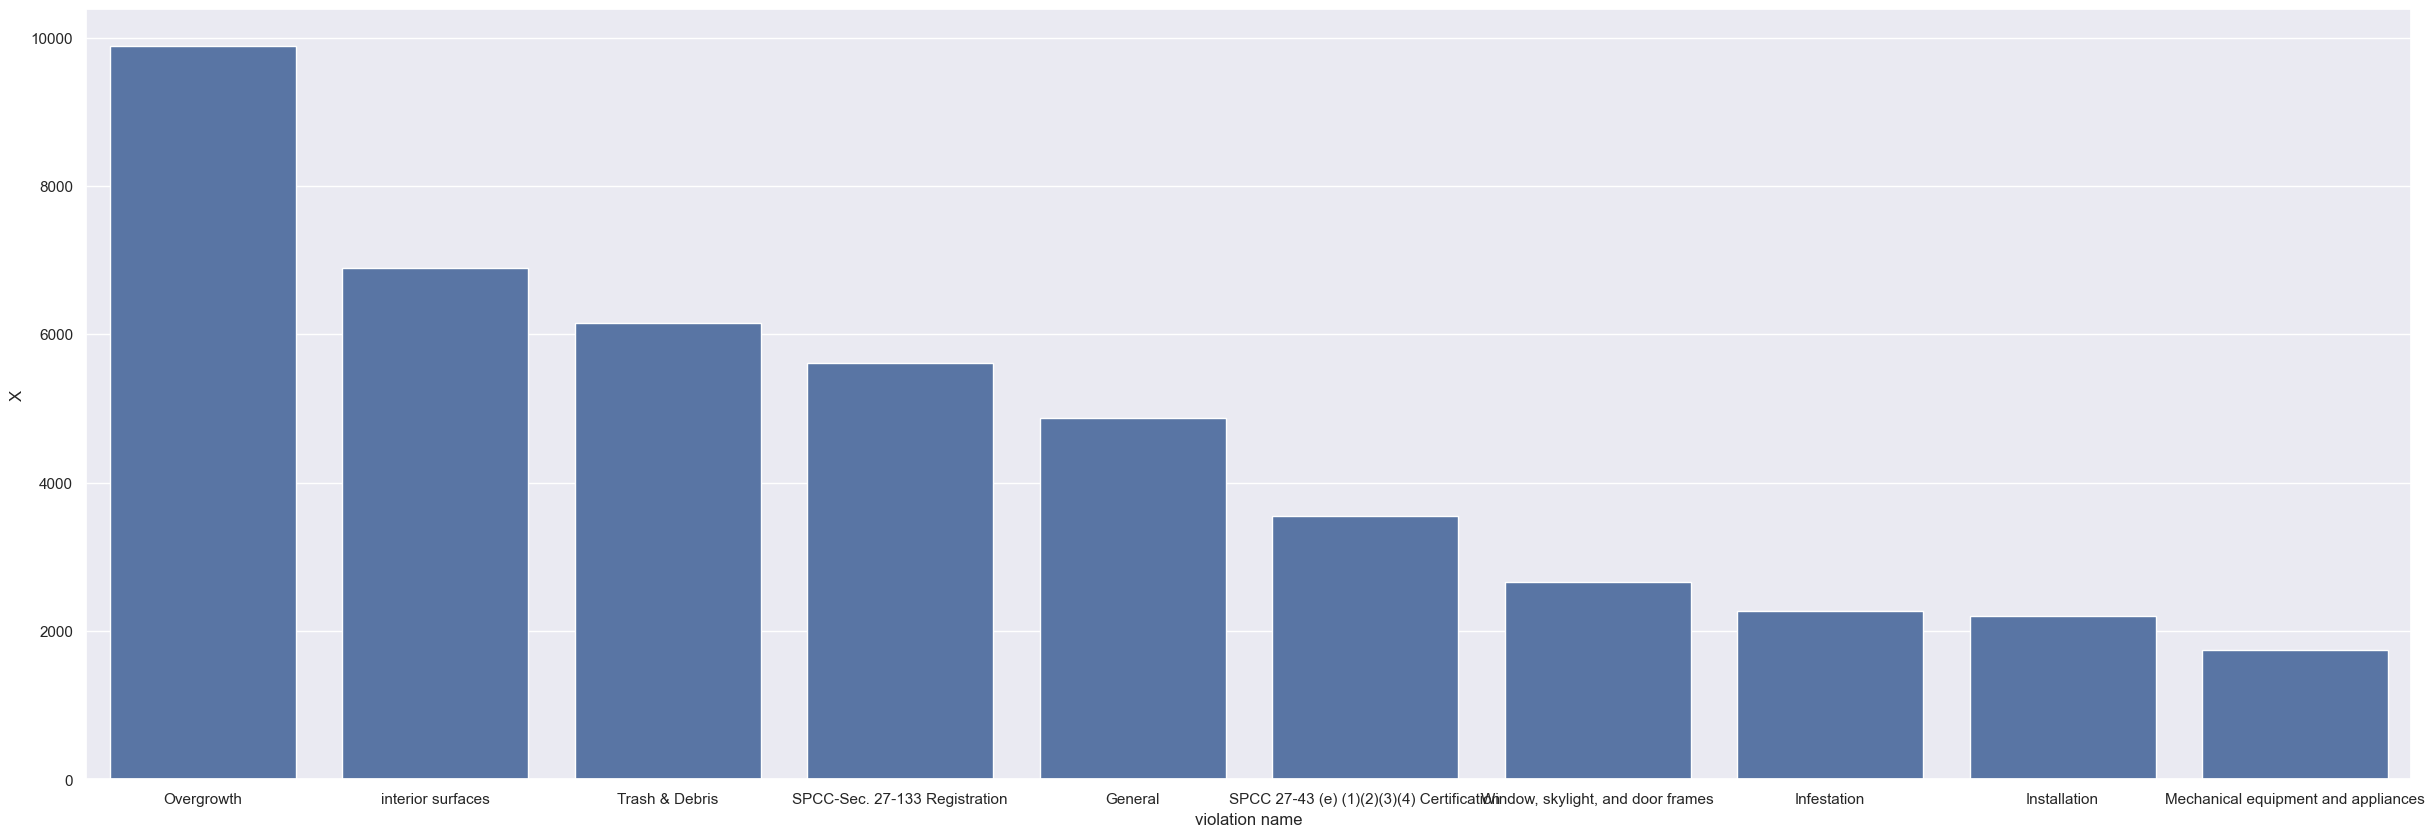

In [23]:
# 90% of the counts of violations are under 200 cases through about 5 years, what about the most frequent ones?
top10_frequent_violations=violation_counts[violation_counts['X']>200].head(10)
sns.set(rc={'figure.figsize':(30, 10)})
sns.barplot(x='violation name',y='X',data=top10_frequent_violations)
# we could generate a simple version of this 'violation' column, excluding information not so useful like 'SPCC - ' etc.

In [18]:
# 3. What are the complaint types and how frequent is each type
complaint_counts=code_violations.groupby('complaint_type_name')['X'].count().to_frame().sort_values(by=['X'],ascending=False)
complaint_counts=complaint_counts.reset_index()
complaint_counts.describe(percentiles=[.25,.75,.90])

,X
count,43.000000
mean,2288.395349
std,6358.091905
min,1.000000
25%,7.500000
50%,95.000000
75%,637.500000
90%,7745.400000
max,35927.000000


<AxesSubplot:xlabel='complaint_type_name', ylabel='X'>

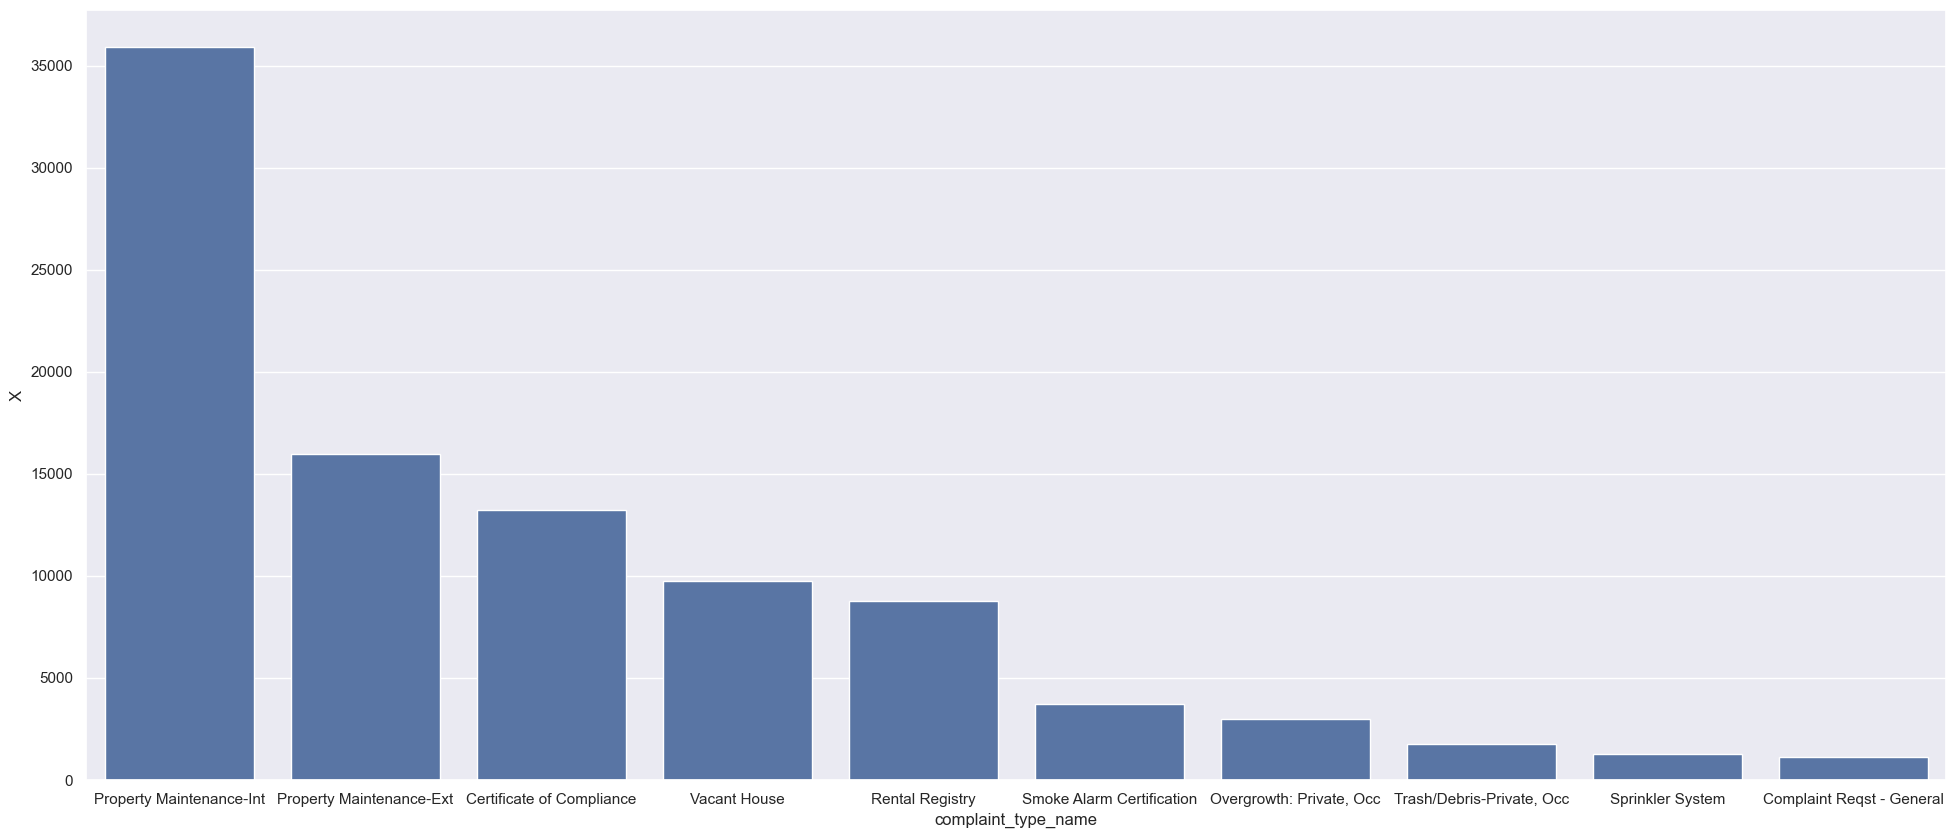

In [19]:
# what about the most frequent complaints?
top10_frequent_complaints=complaint_counts[complaint_counts['X']>200].head(10)
sns.set(rc={'figure.figsize':(24, 10)})
sns.barplot(x='complaint_type_name',y='X',data=top10_frequent_complaints)

Step 3. Answering potential questions

In [30]:
# Question 1 Is there any correlation between neighborhood/location and type of violation?  
# 1. Total case number within each neighborhood
total_case_neighborhood=code_violations.groupby('Neighborhood')['violation'].count().to_frame().sort_values('violation',ascending=False)
total_case_neighborhood.columns=['total_case_count']
# 2. Total violation type within each neighborhood
unique_violation_neighborhood=code_violations.groupby('Neighborhood')['violation'].nunique().to_frame().sort_values('violation',ascending=False)
unique_violation_neighborhood.columns=['unique_violation_count']
# 3. Total complaint type within each neighborhood
unique_complaint_neighborhood=code_violations.groupby('Neighborhood')['complaint_type_name'].nunique().to_frame().sort_values('complaint_type_name',ascending=False)
unique_complaint_neighborhood.columns=['unique_complaint_count']
compare_table=pd.concat([total_case_neighborhood,unique_violation_neighborhood,unique_complaint_neighborhood],axis=1)
compare_table

,total_case_count,unique_violation_count,unique_complaint_count
Neighborhood,,,
Northside,15467,406,30
Near Westside,7859,322,29
Brighton,7423,281,21
Washington Square,5503,305,26
Eastwood,5428,314,24
Park Ave,4535,263,19
Elmwood,4513,221,22
Southside,4368,236,20
Southwest,3818,241,21


Text(0.5, 1.0, 'compare_table.corr()')

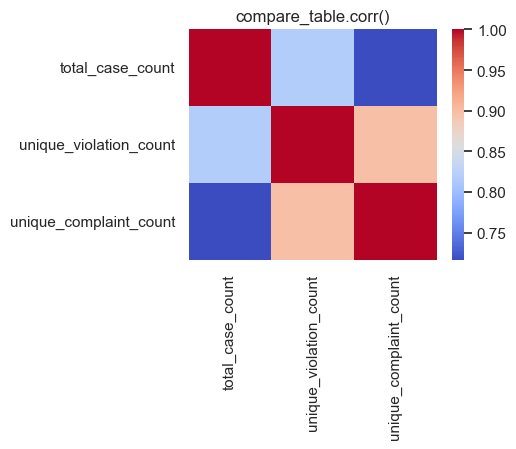

In [32]:
sns.set(rc={'figure.figsize':(4, 3)})
sns.heatmap(compare_table.corr(),cmap='coolwarm')
plt.title('compare_table.corr()')
# Obviously these numers are highly correlated, the more cases recorded, the more unique violation types one neighborhood would have, but the complaint type 